# Neural Painting

### Imitate the image with different painting styles and generates the drawing progress.

Original Author: [Zhengxia Zou](https://github.com/jiupinjia)

Provided by: [BreezeWhite](https://github.com/BreezeWhite)

Original Github: https://github.com/jiupinjia/stylized-neural-painting

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BreezeWhite/interesting-colabs/blob/main/scripts/NeuralPainting.ipynb)

In [ ]:
#@title Setup

!git clone https://github.com/jiupinjia/stylized-neural-painting
%cd stylized-neural-painting


CHECKPOINT_NAME_ID_MAP = {
    'oil-paint-brush': '1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG',
    'watercolor-ink': '19Yrj15v9kHvWzkK9o_GSZtvQaJPmcRYQ',
    'marker-pen': '1XsjncjlSdQh2dbZ3X1qf1M8pDc8GLbNy',
    'color-tapes': '162ykmRX8TBGVRnJIof8NeqN7cuwwuzIF'
}

for model, fid in CHECKPOINT_NAME_ID_MAP.items():
  !wget "https://docs.google.com/uc?export=download&confirm=t&id={fid}" -O {model}.zip
  !unzip {model}.zip



from base64 import b64encode

import numpy as np
import torch
from torch import optim
from IPython.display import HTML

from utils import img2patches, set_requires_grad


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def optimize_x(pt):
    pt._load_checkpoint()
    pt.net_G.eval()

    print('begin drawing...')

    PARAMS = np.zeros([1, 0, pt.rderr.d], np.float32)

    if pt.rderr.canvas_color == 'white':
        CANVAS_tmp = torch.ones([1, 3, 128, 128]).to(device)
    else:
        CANVAS_tmp = torch.zeros([1, 3, 128, 128]).to(device)

    for idx, pt.m_grid in enumerate(range(1, pt.max_divide+1)):

        pt.img_batch = img2patches(pt.img_, pt.m_grid, pt.net_G.out_size).to(device)
        pt.G_final_pred_canvas = CANVAS_tmp

        pt.initialize_params()
        pt.x_ctt.requires_grad = True
        pt.x_color.requires_grad = True
        pt.x_alpha.requires_grad = True
        set_requires_grad(pt.net_G, False)

        pt.optimizer_x = optim.RMSprop([pt.x_ctt, pt.x_color, pt.x_alpha], lr=pt.lr, centered=True)

        pt.step_id = 0
        for sub_idx, pt.anchor_id in enumerate(range(0, pt.m_strokes_per_block)):
            print(f'Grid: {idx+1}/{pt.max_divide}, Strokes: {sub_idx+1}/{pt.m_strokes_per_block}')
            pt.stroke_sampler(pt.anchor_id)
            iters_per_stroke = int(500 / pt.m_strokes_per_block)
            for i in range(iters_per_stroke):
                pt.G_pred_canvas = CANVAS_tmp

                # update x
                pt.optimizer_x.zero_grad()

                pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
                pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
                pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

                pt._forward_pass()
                pt._backward_x()

                pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
                pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
                pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

                pt.optimizer_x.step()
                pt.step_id += 1

        v = pt._normalize_strokes(pt.x)
        v = pt._shuffle_strokes_and_reshape(v)
        PARAMS = np.concatenate([PARAMS, v], axis=1)
        CANVAS_tmp = pt._render(PARAMS, save_jpgs=False, save_video=False)
        CANVAS_tmp = img2patches(CANVAS_tmp, pt.m_grid + 1, pt.net_G.out_size).to(device)

    pt._save_stroke_params(PARAMS)
    final_rendered_image = pt._render(PARAMS, save_jpgs=False, save_video=True)

    return final_rendered_image
  

def video(video_path, video_width=600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""
      <video width={video_width} controls>
        <source src="{video_url}" type="video/mp4">
      </video>
    """)

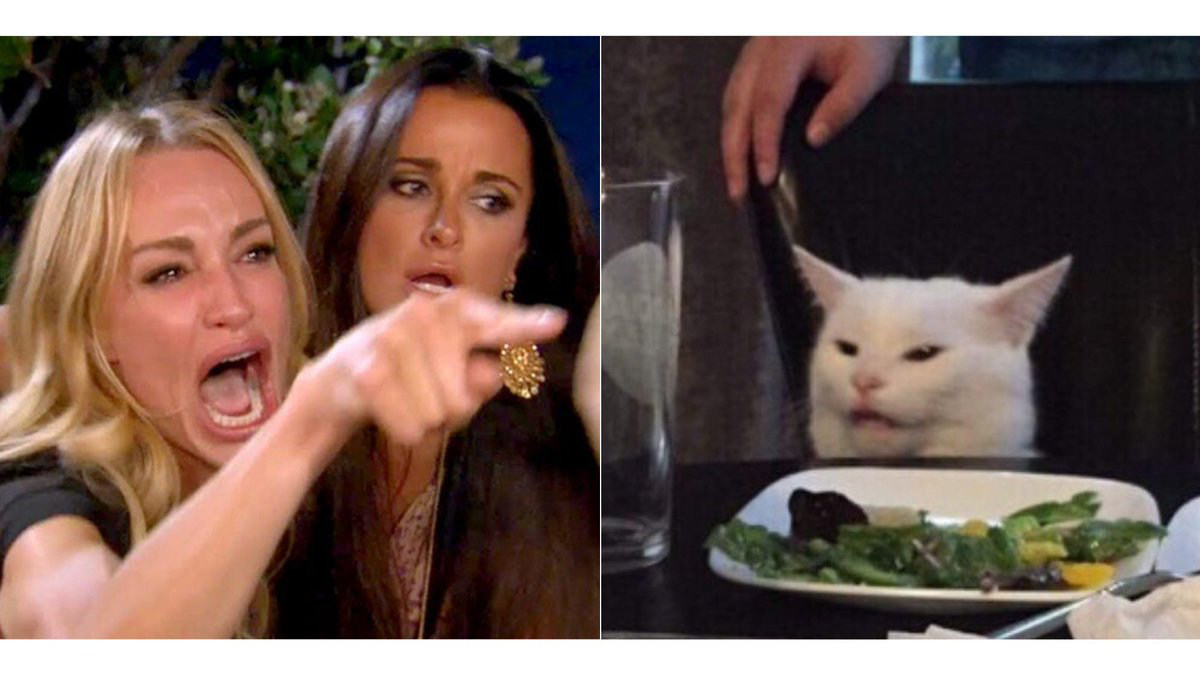

In [26]:
#@title Upload Image

from google.colab import files
from IPython.display import display
from PIL import Image


ff = files.upload()
f_name = list(ff.keys())[0]
display(Image.open(f_name))

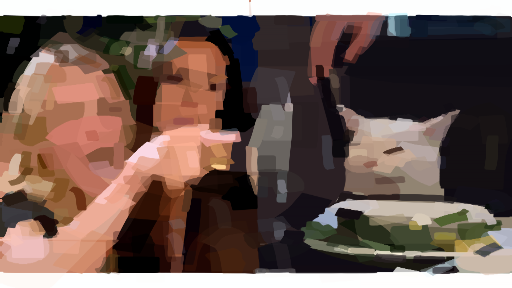

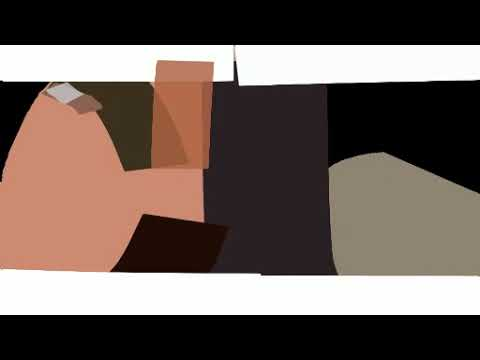

In [7]:
#@title Run

import os
from IPython.display import clear_output
from argparse import Namespace
from painter import ProgressivePainter


renderer = 'marker-pen'  #@param ['watercolor', 'marker-pen', 'oil-paint-brush', 'rectangle']
canvas_color = 'black' #@param ['black', 'white']


checkpoint_path = {
    'oil-paint-brush': 'checkpoints_G_oilpaintbrush',
    'watercolor': 'checkpoints_G_watercolor',
    'marker-pen': 'checkpoints_G_markerpen',
    'rectangle': 'checkpoints_G_rectangle'
}[renderer]


# settings
args = Namespace(
  renderer=renderer.replace('-', ''),
  canvas_color=canvas_color,
  renderer_checkpoint_dir=checkpoint_path,
  output_dir='./output',  # dir to save painting results
  img_path=f_name,  # Path to input photo
  canvas_size=512,  # Size of the canvas for stroke rendering'
  keep_aspect_ratio=True,  # Whether to keep input aspect ratio when saving outputs
  max_m_strokes=500,  # Max number of strokes
  max_divide=5,  # Divide an image up-to max_divide x max_divide patches
  beta_L1=1.0,  # Weight for L1 loss
  with_ot_loss=False,  # Set True for imporving the convergence by using optimal transportation loss, but will slow-down the speed
  beta_ot=0.1,  # Weight for optimal transportation loss
  net_G='zou-fusion-net',  # Renderer architecture [plain-dcgan, plain-unet, huang-net, zou-fusion-net]
  lr=0.005,  # Learning rate for stroke searching
  disable_preview=True # Disable cv2.imshow, for running remotely without x-display
)

pt = ProgressivePainter(args=args)
final_rendered_image = optimize_x(pt)

clear_output()
basename = os.path.splitext(f_name)[0]
video_path = f'{args.output_dir}/{basename}_animated.mp4'
# display(video(video_path))
img = (final_rendered_image * 255).astype(np.uint8)
display(Image.fromarray(img))

files.download(video_path)